In [8]:
import torch
def format_pytorch_version(version):
  return version.split('+')[0]
TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)
def format_cuda_version(version):
  return 'cu' + version.replace('.', '')
CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)
!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 
!pip install pyg
import os.path as osp
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html


In [6]:
from torch_geometric.nn.conv.gatv2_conv import GATv2Conv

In [ ]:
#@title Cora Dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=T.NormalizeFeatures())
data = dataset[0]

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = GATv2Conv(in_channels, 8, heads=8, dropout=0.6)
        self.conv2 = GATv2Conv(8 * 8, out_channels, heads=1, concat=False,
                             dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset.num_features, dataset.num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


@torch.no_grad()
def test(data):
    model.eval()
    out, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        acc = float((out[mask].argmax(-1) == data.y[mask]).sum() / mask.sum())
        accs.append(acc)
    return accs


for epoch in range(1, 201):
    train(data)
    train_acc, val_acc, test_acc = test(data)
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')

Epoch: 001, Train: 0.1357, Val: 0.3140, Test: 0.3190
Epoch: 002, Train: 0.1357, Val: 0.3160, Test: 0.3240
Epoch: 003, Train: 0.2714, Val: 0.3640, Test: 0.4000
Epoch: 004, Train: 0.4857, Val: 0.5060, Test: 0.5270
Epoch: 005, Train: 0.5500, Val: 0.5540, Test: 0.5720
Epoch: 006, Train: 0.6714, Val: 0.6760, Test: 0.6770
Epoch: 007, Train: 0.7571, Val: 0.6620, Test: 0.6710
Epoch: 008, Train: 0.7071, Val: 0.5380, Test: 0.5350
Epoch: 009, Train: 0.5857, Val: 0.4080, Test: 0.4020
Epoch: 010, Train: 0.5929, Val: 0.4100, Test: 0.4030
Epoch: 011, Train: 0.6357, Val: 0.4380, Test: 0.4330
Epoch: 012, Train: 0.6571, Val: 0.4420, Test: 0.4450
Epoch: 013, Train: 0.7286, Val: 0.4800, Test: 0.4810
Epoch: 014, Train: 0.8000, Val: 0.5360, Test: 0.5200
Epoch: 015, Train: 0.8000, Val: 0.5580, Test: 0.5380
Epoch: 016, Train: 0.8214, Val: 0.5900, Test: 0.5860
Epoch: 017, Train: 0.8357, Val: 0.6140, Test: 0.6160
Epoch: 018, Train: 0.8643, Val: 0.6360, Test: 0.6460
Epoch: 019, Train: 0.8714, Val: 0.6140, Test: 

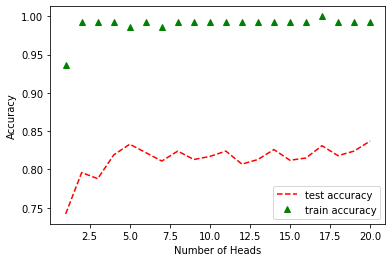

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, headsIn):
        super().__init__()

        self.conv1 = GATv2Conv(in_channels, 8, heads=headsIn, dropout=0.6)
        self.conv2 = GATv2Conv(headsIn * 8, out_channels, heads=1, concat=False,
                             dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)




def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


@torch.no_grad()
def test(data):
    model.eval()
    out, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        acc = float((out[mask].argmax(-1) == data.y[mask]).sum() / mask.sum())
        accs.append(acc)
    return accs


test_accuracies = []
train_accuracies = []
for i in range(1, 21):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = Net(dataset.num_features, dataset.num_classes, i).to(device)
  data = data.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
  for epoch in range(1, 201):
    train(data)
    train_acc, val_acc, test_acc = test(data)
    #print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, 'f'Test: {test_acc:.4f}')
    if epoch == 200:
      test_accuracies.append(test_acc)
      train_accuracies.append(train_acc)
plt.plot(range(1,21), test_accuracies, 'r--', range(1,21), train_accuracies, 'g^')
plt.xlabel('Number of Heads')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'])
plt.show()

In [2]:
#@title Citeseer Dataset
dataset = 'Citeseer'
dataset = Planetoid(root='/tmp/Citeseer', name=dataset, transform=T.NormalizeFeatures())
data = dataset[0]

Processing...
Done!


In [5]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = GATv2Conv(in_channels, 8, heads=8, dropout=0.6)
        self.conv2 = GATv2Conv(8 * 8, out_channels, heads=1, concat=False,
                             dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset.num_features, dataset.num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


@torch.no_grad()
def test(data):
    model.eval()
    out, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        acc = float((out[mask].argmax(-1) == data.y[mask]).sum() / mask.sum())
        accs.append(acc)
    return accs


for epoch in range(1, 201):
    train(data)
    train_acc, val_acc, test_acc = test(data)
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')

Epoch: 001, Train: 0.3000, Val: 0.2760, Test: 0.2740
Epoch: 002, Train: 0.1833, Val: 0.1400, Test: 0.1600
Epoch: 003, Train: 0.1750, Val: 0.1380, Test: 0.1600
Epoch: 004, Train: 0.1750, Val: 0.1420, Test: 0.1610
Epoch: 005, Train: 0.2750, Val: 0.1820, Test: 0.1920
Epoch: 006, Train: 0.4250, Val: 0.2540, Test: 0.2880
Epoch: 007, Train: 0.3750, Val: 0.2940, Test: 0.2980
Epoch: 008, Train: 0.2917, Val: 0.1900, Test: 0.2090
Epoch: 009, Train: 0.2083, Val: 0.1740, Test: 0.1830
Epoch: 010, Train: 0.1917, Val: 0.1720, Test: 0.1830
Epoch: 011, Train: 0.1917, Val: 0.1740, Test: 0.1820
Epoch: 012, Train: 0.2417, Val: 0.1780, Test: 0.1840
Epoch: 013, Train: 0.3167, Val: 0.1900, Test: 0.2010
Epoch: 014, Train: 0.4000, Val: 0.2220, Test: 0.2340
Epoch: 015, Train: 0.5250, Val: 0.3360, Test: 0.3640
Epoch: 016, Train: 0.6750, Val: 0.4240, Test: 0.4580
Epoch: 017, Train: 0.8000, Val: 0.3940, Test: 0.4440
Epoch: 018, Train: 0.8500, Val: 0.3880, Test: 0.4390
Epoch: 019, Train: 0.8500, Val: 0.4120, Test: 

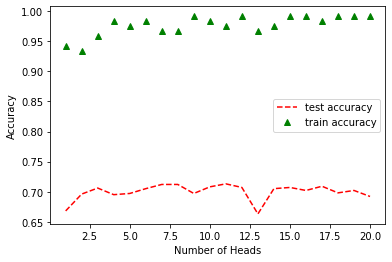

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, headsIn):
        super().__init__()

        self.conv1 = GATv2Conv(in_channels, 8, heads=headsIn, dropout=0.6)
        self.conv2 = GATv2Conv(headsIn * 8, out_channels, heads=1, concat=False,
                             dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)




def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


@torch.no_grad()
def test(data):
    model.eval()
    out, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        acc = float((out[mask].argmax(-1) == data.y[mask]).sum() / mask.sum())
        accs.append(acc)
    return accs


test_accuracies = []
train_accuracies = []
for i in range(1, 21):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = Net(dataset.num_features, dataset.num_classes, i).to(device)
  data = data.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0005)
  for epoch in range(1, 201):
    train(data)
    train_acc, val_acc, test_acc = test(data)
    #print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, 'f'Test: {test_acc:.4f}')
    if epoch == 200:
      test_accuracies.append(test_acc)
      train_accuracies.append(train_acc)
plt.plot(range(1,21), test_accuracies, 'r--', range(1,21), train_accuracies, 'g^')
plt.xlabel('Number of Heads')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'])
plt.show()

In [ ]:
#@title Pubmed Dataset
dataset = 'Pubmed'
dataset = Planetoid(root='/tmp/Pubmed', name = dataset, transform=T.NormalizeFeatures())
data = dataset[0]

In [9]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = GATv2Conv(in_channels, 8, heads=8, dropout=0.6)
        self.conv2 = GATv2Conv(8 * 8, out_channels, heads=8, concat=False,
                             dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset.num_features, dataset.num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)


def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


@torch.no_grad()
def test(data):
    model.eval()
    out, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        acc = float((out[mask].argmax(-1) == data.y[mask]).sum() / mask.sum())
        accs.append(acc)
    return accs


for epoch in range(1, 201):
    train(data)
    train_acc, val_acc, test_acc = test(data)
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')

Epoch: 001, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 002, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 003, Train: 0.4667, Val: 0.4200, Test: 0.4410
Epoch: 004, Train: 0.4667, Val: 0.2680, Test: 0.2650
Epoch: 005, Train: 0.5167, Val: 0.3420, Test: 0.3270
Epoch: 006, Train: 0.6333, Val: 0.4760, Test: 0.4400
Epoch: 007, Train: 0.6500, Val: 0.5500, Test: 0.5190
Epoch: 008, Train: 0.6167, Val: 0.5480, Test: 0.5250
Epoch: 009, Train: 0.6167, Val: 0.5320, Test: 0.5210
Epoch: 010, Train: 0.6167, Val: 0.5320, Test: 0.5180
Epoch: 011, Train: 0.6167, Val: 0.5320, Test: 0.5180
Epoch: 012, Train: 0.6333, Val: 0.5440, Test: 0.5290
Epoch: 013, Train: 0.7167, Val: 0.5600, Test: 0.5520
Epoch: 014, Train: 0.8000, Val: 0.6200, Test: 0.6170
Epoch: 015, Train: 0.8333, Val: 0.6600, Test: 0.6640
Epoch: 016, Train: 0.8500, Val: 0.6940, Test: 0.6800
Epoch: 017, Train: 0.9000, Val: 0.7120, Test: 0.6880
Epoch: 018, Train: 0.9000, Val: 0.7380, Test: 0.7030
Epoch: 019, Train: 0.9000, Val: 0.7420, Test: 

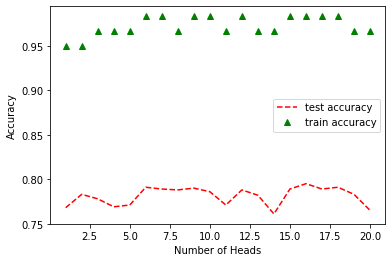

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, headsIn):
        super().__init__()

        self.conv1 = GATv2Conv(in_channels, 8, heads=headsIn, dropout=0.6)
        self.conv2 = GATv2Conv(headsIn * 8, out_channels, heads=8, concat=False,
                             dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)




def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


@torch.no_grad()
def test(data):
    model.eval()
    out, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        acc = float((out[mask].argmax(-1) == data.y[mask]).sum() / mask.sum())
        accs.append(acc)
    return accs


test_accuracies = []
train_accuracies = []
for i in range(1, 21):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = Net(dataset.num_features, dataset.num_classes, i).to(device)
  data = data.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)
  for epoch in range(1, 201):
    train(data)
    train_acc, val_acc, test_acc = test(data)
    #print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, 'f'Test: {test_acc:.4f}')
    if epoch == 200:
      test_accuracies.append(test_acc)
      train_accuracies.append(train_acc)
plt.plot(range(1,21), test_accuracies, 'r--', range(1,21), train_accuracies, 'g^')
plt.xlabel('Number of Heads')*8855
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'])
plt.show()